# Simulation, WP matrix

in this notebook I compare the simulated waveform simply using the WP from COMSOL with alpha events

In [ ]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.WaveformAnalysis import Waveform
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uproot

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15

In [2]:
tree = uproot.open('/usr/workspace/wsa/nexo/jacopod/WP_3dfine.root')

(72.0, 76.0)

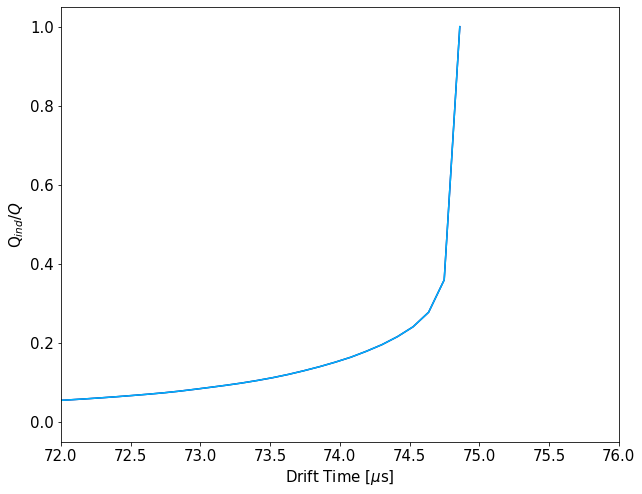

In [3]:
strip = 11
strip_to_gang = 1
k0 = tree.keys()[strip]
ix = np.where(tree[k0].values==1)
t = np.flip(np.array(tree[k0]._fZaxis._fXbins[:-1])/1.79)
ganged_wfm = np.zeros(t.shape)
x_loc = tree[k0]._fXaxis._fXbins[ix[0][0]]
colors = plt.cm.jet(np.linspace(0,0.3,strip_to_gang+1))
for i,k in enumerate(tree.keys()[strip:strip+strip_to_gang]):
    x_bin = tree[k]._fXaxis._fXbins
    ix_loc = np.where(x_bin>=x_loc)[0][0]
    wfm = np.flip(tree[k].values[ix_loc,ix[1][0],:])
    keep_point = wfm!=0
    keep_point[0]  = True
    keep_point[-1] = True
    f = interp1d((t[0]-t)[keep_point], wfm[keep_point], kind='linear')
    ganged_wfm += f(t[0]-t)
    plt.plot((t[0]-t), f(t[0]-t), color=colors[i])
plt.plot((t[0]-t), ganged_wfm, color=colors[-1])
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('Q$_{ind}/Q$')
plt.xlim(72,76)
#plt.ylim(0.00001,1)
#plt.yscale('log')

this is the waveform from one channel zoomed in around the collection time

In [4]:
def get_t(t,wfm,fraction):
    return t[np.argmin(np.abs(wfm-fraction))]

raw [1.23232677 0.22405941 0.06401697]
smoothed [0.94425038 0.48012731 0.72019097]


(73.18740644738085, 75.3319751033942)

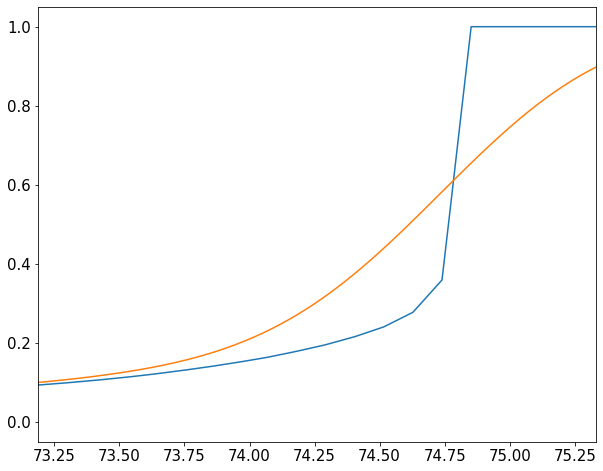

In [5]:
padding_sample = 2000
sampling_time_us = 0.016
smoothing_window_us = 0.5
smoothing_window_sample = int(smoothing_window_us/sampling_time_us)
t_f = t[0] + sampling_time_us*padding_sample
t_smoothing = np.linspace(t[-1],t[0],int(t[0]/sampling_time_us))
t_padded = np.linspace(t[-1],t_f,int(t_f/sampling_time_us))
wfm_padded = np.pad(f(t_smoothing),(0,padding_sample),'edge')
smoothed_wfm = gaussian_filter(wfm_padded,smoothing_window_sample)
plt.plot(t_padded,wfm_padded)
plt.plot(t_padded,smoothed_wfm)
t10 = get_t(t_padded,wfm_padded,0.1)
t25 = get_t(t_padded,wfm_padded,0.25)
t50 = get_t(t_padded,wfm_padded,0.5)
t90 = get_t(t_padded,wfm_padded,0.9)
smoothed_t10 = get_t(t_padded,smoothed_wfm,0.1)
smoothed_t25 = get_t(t_padded,smoothed_wfm,0.25)
smoothed_t50 = get_t(t_padded,smoothed_wfm,0.5)
smoothed_t90 = get_t(t_padded,smoothed_wfm,0.9)
print('raw', np.diff([t10,t25,t50,t90]))
print('smoothed',np.diff([smoothed_t10,smoothed_t25,smoothed_t50,smoothed_t90]))
plt.xlim(smoothed_t10,smoothed_t90)

In [6]:
run_parameters_file = '/g/g90/jacopod/software/TMSAnalysis/config/Run_Parameters_Xe_Run29_SimCompatible.csv'
calibrations_file = '/g/g90/jacopod/software/TMSAnalysis/config/Calibrations_Xe_Run11b.csv'
channel_map_file = '/g/g90/jacopod/software/TMSAnalysis/config/Channel_Map_Xe_Run29_MCIncluded.csv'
sample_window = 1000
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile( run_parameters_file )
analysis_config.GetCalibrationConstantsFromFile( calibrations_file )
analysis_config.GetChannelMapFromFile( channel_map_file )
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']
path_to_reduced = '/p/lustre1/jacopod/29th/analysis_500ns/'
!ls $path_to_reduced

20200207_PreRecirculation    20200212_RecoverY17X19
20200210_AfterRecirculation  20200213_AfterRnInjection
20200211_AfterRecirculation  20200213_DuringRnInjection
20200212_RecirculationOff


## Alpha comparison

In [7]:
folder = '20200213_AfterRnInjection'
df = pd.read_hdf(path_to_reduced + folder + '/reduced_added.h5')
df['DriftTime'] = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
df['Purity-Corrected Energy'] = df['TotalTileEnergy']*np.exp(df['DriftTime']/165.9)
for k in df.keys():
    print(k)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
TileStrip X1-12 Baseline
TileStrip X1-12 Baseline RMS
TileStrip X1-12 Charge Energy
TileStrip X1-12 Drift Time
TileStrip X1-12 T10
TileStrip X1-12 T25
TileStrip X1-12 T50
TileStrip X1-12 T90
TileStrip X13 Baseline
TileStrip X13 Baseline RMS
TileStrip X13 Charge Energy
TileStrip X13 Drift Time
TileStrip X13 T10
TileStrip X13 T25
TileStrip X13 T50
TileStrip X13 T90
TileStrip X14 Baseline
TileStrip X14 Baseline RMS
TileStrip X14 Charge Energy
TileStrip X14 Drift Time
TileStrip X14 T10
TileStrip X14 T25
TileStrip X14 T50
TileStrip X14 T90
TileStrip X15 Baseline
TileStrip X15 Baseline RMS
Til

In [8]:
mask_channel_energy = np.logical_or(df['TileStrip X14 Charge Energy']>200,df['TileStrip Y14 Charge Energy']>200)
mask = (df['Purity-Corrected Energy']>600) & (df['Purity-Corrected Energy']<800) &\
(df['DriftTime']<75) & (df['NumTileChannelsHit']==1) & mask_channel_energy#(df['TileStrip X16 Charge Energy']>200)
selection_index = df[mask].index
wfm_sample = 480
t_data = np.arange(sample_window)*sampling_time_us

In [9]:
#norm_wfm = np.zeros((wfm_sample,sample_window))
#for i,e in enumerate(selection_index[:wfm_sample]):
#    event = Waveform.Event('/p/lustre1/jacopod/29th/analysis_500ns/{}/reduced_added.h5'.format(folder),\
#                       '/p/lustre1/jacopod/29th/{}/tier1/'.format(folder),e,\
#                   run_parameters_file,\
#                   calibrations_file,\
#                   channel_map_file)
#    event.smooth(0.5)
#    #trigger_position = event.waveform['X14'].trigger_position
#    #cathode_ix = int(93/sampling_time_us)
#    t_90 = df['TileStrip X16 T90'][e]
#    wfm_data = event.waveform['X16'].data
#    try:
#        norm_wfm[i] =\
#        ((wfm_data-np.mean(wfm_data[:200]))/df['TotalTileEnergy'][e])[int(t_90-sample_window):int(t_90)]
#    except ValueError:
#        continue
#    if i%50 == 0:
#        print(i)
#np.save('wfm_sample_alphas_X16.npy',norm_wfm)

In [10]:
def fit_test(wfm,test):
    if len(np.shape(wfm)) == 1:
        cumulative_wfm = np.cumsum(np.abs(wfm))/np.cumsum(np.abs(wfm))[-1]
        cumulative_test = np.cumsum(test)/np.cumsum(test)[-1]
        return max(np.abs(cumulative_wfm-cumulative_test))
    cumulative_wfm = np.cumsum(np.abs(wfm),axis=1)
    cumulative_wfm[cumulative_wfm[:,-1]==0] = 1
    cumulative_wfm_norm = np.einsum('ij,i->ij',cumulative_wfm,1/cumulative_wfm[:,-1])
    cumulative_test_norm = np.cumsum(test)/np.cumsum(test)[-1]
    ks_score = np.amax(np.abs(cumulative_wfm_norm-cumulative_test_norm),axis=1)
    return ks_score

For this comparison an important step is to align all the data waveforms in time, in this case I chose T90

Text(0, 0.5, 'KS score')

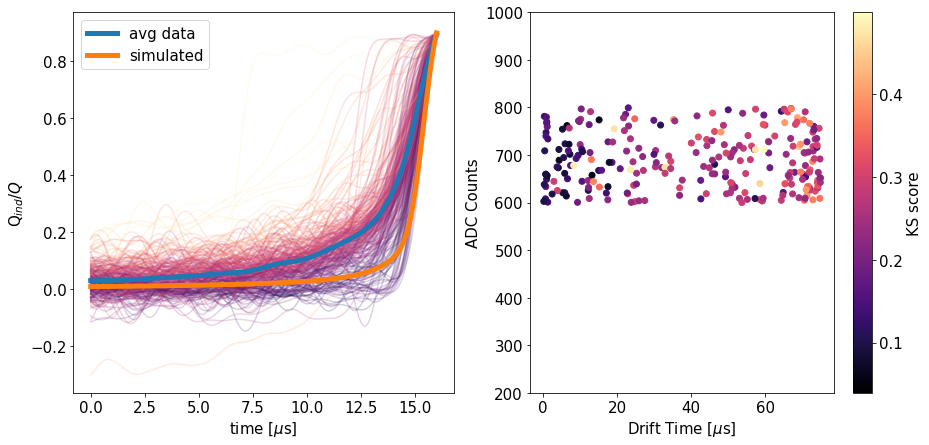

In [11]:
data = np.load('wfm_sample_alphas_X16.npy')
norm_wfm = data[:,1:]
selection_index = data[:,0]
bin_t90 = int(smoothed_t90/sampling_time_us)
keep_ix = np.mean(norm_wfm,axis=1)<0.5
keep_ix_df = selection_index[keep_ix]
chi2 = fit_test(norm_wfm[keep_ix],smoothed_wfm[bin_t90-sample_window:bin_t90])
mask_chi2 = chi2<0.5
colors = plt.cm.magma(chi2[mask_chi2]/max(chi2[mask_chi2]))
fig,ax = plt.subplots(1,2,figsize=(15,7))
selected_wfm = norm_wfm[keep_ix][mask_chi2]
selected_df = df.iloc[keep_ix_df][mask_chi2]
for i,e in enumerate(selected_wfm):
    ax[0].plot(t_data,e,color=colors[i],alpha=0.2)
ax[0].plot(t_data,np.mean(selected_wfm,axis=0),linewidth=5,label='avg data')
ax[0].plot(t_data,smoothed_wfm[bin_t90-sample_window:bin_t90],linewidth=5,label='simulated')
ax[0].legend()
ax[0].set_xlabel('time [$\mu$s]')
ax[0].set_ylabel('Q$_{ind}/Q$')
scatter = ax[1].scatter(selected_df['TileStrip X16 Drift Time'],selected_df['Purity-Corrected Energy'],\
            c=chi2[mask_chi2],cmap='magma')
ax[1].set_xlabel('Drift Time [$\mu$s]')
ax[1].set_ylabel('ADC Counts')
ax[1].set_ylim(200,1000)
cbar = fig.colorbar(scatter)
cbar.ax.set_ylabel('KS score')

noise and pile up smear the correct alignment, it is possible to see how the averaged waveform is longer than the smoothed simulated one. Waveforms are color-coded based on the Kolmogorov-Smirnov score. On the left, it is possible to see a mild correlation between drift time and KS score. The degradation of the goodness of the fit with the drift time could be related to the longitudinal diffusion. In the next block, I slice the cell in different drift times to look and look at the goodness of the fit

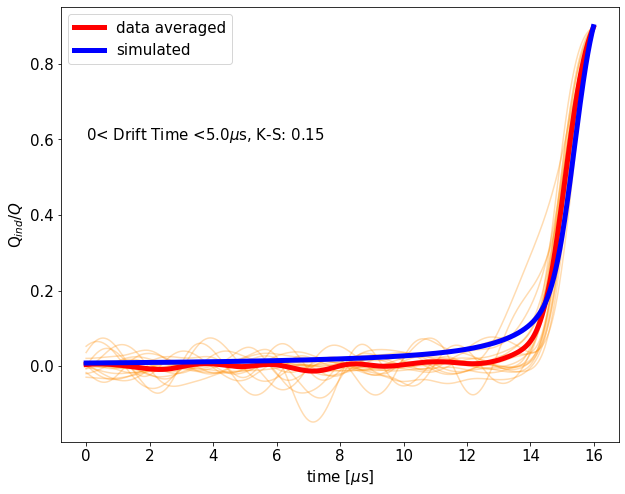

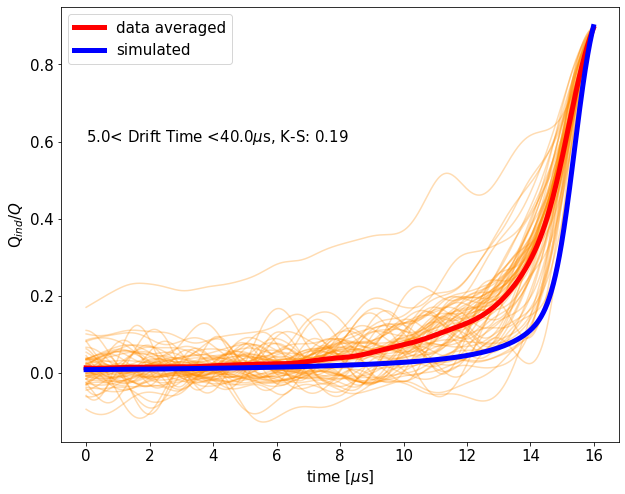

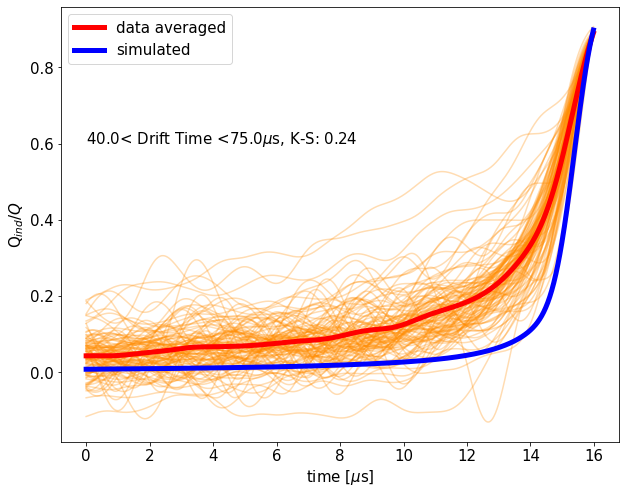

In [12]:
differential_wfm = np.diff(selected_wfm,axis=1)
inflection_point = np.argmax(differential_wfm,axis=1)
wait_time_us = 1.2
align_ix = inflection_point>sample_window - wait_time_us/sampling_time_us
selected_wfm = selected_wfm[align_ix]
selected_df = selected_df[align_ix]
time_slice = 3
time_bin = np.linspace(5,75,time_slice)
array_bin = np.digitize(selected_df['DriftTime'],time_bin)
ks_window = int(6/sampling_time_us)
first = True
for i in range(time_slice):
    if first:
        a = 0
        first = False
    else:
        a = time_bin[i-1]
    mask_slice = array_bin == i
    mean_wfm = np.mean(selected_wfm[mask_slice],axis=0)
    ks = fit_test(mean_wfm[-ks_window:],smoothed_wfm[bin_t90-ks_window:bin_t90])
    plt.plot(t_data,selected_wfm[mask_slice].T,alpha=0.3,color='darkorange')
    plt.plot(t_data,mean_wfm,linewidth=5,label='data averaged',color='red')
    plt.plot(t_data,smoothed_wfm[bin_t90-sample_window:bin_t90],linewidth=5,label='simulated',color='blue')
    plt.xlabel('time [$\mu$s]')
    plt.ylabel('Q$_{ind}/Q$')
    plt.text(0,0.6,'{}< Drift Time <{}$\mu$s, K-S: {:.2}'.format(a,time_bin[i],ks))
    plt.legend()
    plt.show()

The way I removed the wrongly aligned waveforms is to calculate the differential waveform (current), the maximum in the current is the inflection point of the waveform risetime. If the inflection point is distant to the recorded T90 more than wait_time_us=1.2us the event is discarded